# Average atom models: Theoretical background

In this section, we describe the average-atom model that we use and the equations that are solved. For a detailed derivation and discussion of the model, please see our earlier pre-print \cite{callow2021firstprinciples}. As noted in the main text, the most important difference from this previous model is that we do not now distinguish between bound and free KS orbitals, but rather all orbitals follow from the same KS equations and boundary conditions. The second difference is that, in this paper, we solve the spin-unpolarized KS equations; in other words, the spatial spin-up and spin-down orbitals are assumed to be identical, $\phi_i^\uparrow(\vec{r})=\phi_i^\downarrow(\vec{r})$.

We shall first review the important aspects of our model; in the following sub-section, we explain in more detail the band-structure model of Massacrier *et al.* \cite{massacrier_bands} which we have also implemented in atoMEC. As discussed in the main text, we solve the spherically symmetric Kohn--Sham (KS) equations for an atom at finite temperature, with appropriate boundary conditions imposed on the orbitals intended to mimic the effect of interactions from electrons and nuclei in neighbouring atoms. The spherically symmetric KS equations are given by

\begin{equation}
\left[\frac{\textrm{d}^2}{\textrm{d}r} + \frac{2}{r}\frac{\textrm{d}}{\textrm{d}r} - \frac{l(l+1)}{r^2} \right] X_{nl}(r) + 2 \left[\epsilon^{\tau}_{nl} - v_\textrm{s}[n](r) \right] X_{nl}(r) = 0,
\end{equation}

where $v_\textrm{s}[n](r)$ is the KS potential, given by

\begin{equation}
 v_{\textrm{s}}[n](r) = -\frac{Z}{r} + 4\pi \int_0^{R_\textrm{WS}} \textrm{d}{x} \frac{n(x)x^2}{r^>(x)} + \frac{\delta F_\textrm{xc}^\tau [n]}{\delta n(r)}\,,
\end{equation}

where $r^>(x)=\max(r,x)$. The three terms in the potential are respectively the electron-nuclear attraction, the classical Hartree repulsion, and the exchange-correlation (xc) potential, which is equal to the functional derivative of the xc free energy. As ever, due to the dependence of the KS potential on the density $n(r)$, the KS equations must be solved iteratively until self-consistency is reached.

The density $n(r)$ is constructed from the orbitals as

\begin{equation}
n(r) = 2\sum_{nl}(2l+1) f_{nl}(\epsilon_{nl},\mu,\tau) |X_{nl}(r)|^2\,.
\end{equation}

where $f_{nl}(\epsilon_{nl},\mu,\tau)$ the Fermi--Dirac (FD) distribution, given by

\begin{equation}
f_{nl}(\epsilon_{nl},\mu,\tau) = \frac{1}{1+e^{(\epsilon_{nl}-\mu)/\tau}}\,.
\end{equation}

The chemical potential $\mu$ is determined by fixing the electron number $N_\textrm{e}=4\pi\int\textrm{d}r r^2 n(r)$ to be equal to a pre-determined value (in this paper, $N_\textrm{e}=Z$ in all cases). 

As discussed in the main text, we impose boundary conditions on the KS orbitals $X_{nl}(r)$ which are intended to implicitly account for inter-atomic interactions. In our earlier preprint \cite{callow2021firstprinciples}, we argued that a physically intuitive condition was to impose smoothness of the density at the edge of the WS cell,

\begin{equation}
\frac{\textrm{d}n(r)}{\textrm{d}r}\Bigg|_{r=R_\textrm{WS}} =0\,.
\end{equation}

Mathematically there is no unique way to enforce the above condition, but two simple choices are

\begin{align}
0&=X_{nl}(R_\textrm{VS})\,, \\
0&=\frac{\textrm{d}X_{nl}(r)}{\textrm{d}r}\Bigg|_{r=R_\textrm{WS}}\,,
\end{align}

which we refer to respectively as "Dirichlet" and "Neumann" conditions. As discussed in the main text, the energy eigenvalues that result from these boundary conditions also define the upper and lower energy band limits $\epsilon^{\pm}_{nl}$ for the band-structure model. We elaborate on this model in the following sub-section.

## Band-structure AA model

We here elaborate on the band-structure model proposed by Massacrier *et al*, which we have implemented in atoMEC. In this model, the orbitals gain an extra index since we solve the KS equations for all energies in a given band. The KS equations thus become

\begin{equation}
\left[\frac{\textrm{d}^2}{\textrm{d}r} + \frac{2}{r}\frac{\textrm{d}}{\textrm{d}r} - \frac{l(l+1)}{r^2} \right] X_{\epsilon nl}(r) + 2 \left[\epsilon^{\tau}_{nl} - v_\textrm{s}[n](r) \right] X_{\epsilon nl}(r) = 0,
\end{equation}

and the density is given by

\begin{equation}
    n(r) = 2\sum_{nl}(2l+1)
    \int_{\epsilon_{nl}^-}^{\epsilon_{nl}^+} \textrm{d}{\epsilon} g_{nl}(\epsilon) f_{nl}(\epsilon,\mu,\tau) |X_{nl\epsilon}(r)|^2\,,
\end{equation}

with the density-of-states (DOS) $g_{nl}(\epsilon)$ given by the Hubbard DOS,

\begin{gather}
g_{nl}(\epsilon) =\frac{8}{ \pi \Delta_{nl}^2} \sqrt{(\epsilon^+_{nl}-\epsilon)(\epsilon - \epsilon^-_{nl})}\,,\\
\Delta_{nl} = \epsilon^+_{nl}-\epsilon_{nl}^- \,.
\end{gather}

In practise, the energy bands are of discretized, and the above integral becomes a summation over energies within each band which we now denote by index $k$,

\begin{gather}
 n(r) = 2\sum_{knl}(2l+1) \delta\epsilon_{knl} g_{knl}(\epsilon_{knl},\epsilon_{nl}^\pm) f_{knl}(\epsilon_{knl},\mu,\tau) |X_{knl}(r)|^2\,,\\
 g_{knl}(\epsilon_{knl},\epsilon_{nl}^\pm) =\frac{8}{ \pi \Delta_{nl}^2} \sqrt{(\epsilon^+_{nl}-\epsilon_{knl})(\epsilon_{knl} - \epsilon^-_{nl})}\,.
\end{gather}

We now simplify the above expressions. To the best of our knowledge, this simplification was not discussed in the original paper. Firstly, we note that the energy spacing in the discretization of the energy band $\delta\epsilon_{knl}$ can be written as

\begin{equation}
\delta\epsilon_{knl} = \frac{\epsilon^+_{nl} - \epsilon^-_{nl}}{N_k-1} = \frac{\Delta_{nl}}{N_k-1}\,,
\end{equation}

where $N_k$ is the number of $k$ points (the denominator is equal to $N_k-1$ because there are $N_k-1$ spacings for $N_k$ total points). The product $\delta\epsilon_{knl} \times g_{knl}(\epsilon_{knl},\epsilon_{nl}^\pm)$ therefore can be written as

\begin{equation}
\delta\epsilon_{knl} \times g_{knl}(\epsilon_{knl},\epsilon_{nl}^\pm) = \frac{8}{\pi\Delta_{nl}(N_k-1)} \sqrt{(\epsilon^+_{nl}-\epsilon_{knl})(\epsilon_{knl} - \epsilon^-_{nl})}\,.
\end{equation}

We then note that the energies in a band $\epsilon_{knl}$ can be re-written as
\begin{align}
\epsilon_{knl} &= \epsilon_{nl}^- + \frac{k}{N_k-1}\Delta_{nl} \\
               &= \epsilon_{nl}^+ + \frac{k-(N_k-1)}{N_k-1}\Delta_{nl}
\end{align}

Substituting the above expressions into the product $\delta\epsilon_{knl} \times g_{knl}(\epsilon_{knl},\epsilon_{nl}^\pm)$ leads to the following expression:

\begin{equation}
\delta\epsilon_{knl} \times g_{knl}(\epsilon_{knl},\epsilon_{nl}^\pm) = \frac{8}{\pi(N_k-1)^2}\sqrt{k(N_k-1-k)}\,.
\end{equation}

It is clear the above equation is in fact independent of the quantum numbers $n$ and $l$. The density $n(r)$ can therefore be re-expressed as

\begin{gather}
n(r) = 2\sum_{k} w_k \sum_{nl}(2l+1) f_{knl}(\epsilon_{knl},\mu,\tau) |X_{knl}(r)|^2\,,\\
w_k = \frac{8}{\pi(N_k-1)^2}\sqrt{k(N_k-1-k)} \Rightarrow \sum_{k=0}^{N_k-1} w_k =1\,.
\end{gather}

The above expression closely resembles the expression for the density in plane-wave DFT codes, since it has a summation over $k$-points and some weighting $w_k$, very much like the $\vec{k}$ point mesh for reciporacal space used in plane-wave DFT codes. It is also clear to see that when the concept of bands in the AA model is not employed (i.e. when we use either the Dirichlet or Neumann conditions only), that $N_k=1,w_k=1$ and the above expression reduces to the expression for the density in the previous sub-section.

# Introduction to atoMEC

For all calculations in the paper, we have used the open source average-atom code atoMEC. It can be downloaded
from Ref. \onlinecite{atoMEC}.

In this section, we go through the basics of setting up and then running a calcuation in atoMEC.

We first create an `Atom` object which houses the key physical information about the system we want to study, i.e. the temperature and mass density. We start with Aluminium at room temperature:

In [1]:
# first: general set-up and imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import MIS_plots

# set the default printing output
default_stdout = sys.stdout
# base directory:
basedir = os.getcwd()

In [2]:
# import the Atom object
from atoMEC import Atom

# set up the Aluminium atom
Al_atom = Atom("Al", 300, density=2.7, units_temp="K")


Welcome to atoMEC! 

Normal temperature range for atoMEC is 0.01 -- 100 eV 

Atomic information:
 
Atomic species                : Al 
Atomic charge / weight        : 13  / 26.982
Valence electrons             : 3  
Mass density                  : 2.7 g cm^-3
Voronoi sphere radius         : 2.997 Bohr / 1.586 Angstrom
Electronic temperature        : 0.00095 Ha /  0.02585 eV / 300 K
Wigner-Seitz radius           : 2.078 (Bohr)
Ionic coupling parameter      : 2.967e+04
Electron degeneracy parameter : 0.002228




We see this prints some key information about our system, including for example the ionic coupling and electron degeneracy parameters, which are important in warm dense matter (WDM). For details of how these are computed see our initial preprint \cite{callow2021firstprinciples} on AA models and documentation in the code.

Next we set up a `model` object, which contains input regarding which approximations we use in our model, for example the boundary condition and exchange-correlation (xc) approximation.

In [3]:
# import models
from atoMEC import models

# set up the ISModel
Al_model = models.ISModel(
    Al_atom, bc="dirichlet", unbound="quantum", xfunc_id="lda_x", cfunc_id="lda_c_pw"
)

Using Ion-Sphere model
Ion-sphere model parameters: 
 
Spin-polarized                : False
Number of electrons           : 13
Exchange functional           : lda_x
Correlation functional        : lda_c_pw
Boundary condition            : dirichlet
Unbound electron treatment    : quantum
Shift KS potential            : True




In the above, we have set up an ion-sphere model (`ISModel`) which so far is the only kind of AA model implemented in atoMEC. Furthermore, we have specified the following approximations:

* `unbound="quantum"`: This means all our KS orbitals are treated in the same way, regardless of their energy
* `bc="dirichlet"`: The Dirichlet boundary condition (as described in the main text) is applied to the orbitals
* `xfunc_id="lda_x"`, `cfunc_id="lda_c_pw"`: We have chosen the LDA xc functional 

We are now ready to run an SCF calculation, which is done by the `CalcEnergy` function. There are various inputs to this function which control numerical aspects, such as the number of grid points and SCF convergence parameters. Most of these are optional so we use the default values for now.

The two parameters which must be specified are the maximal value of the principal and angular quantum numbers, `nmax` and `lmax`. atoMEC will search for all the eigenvalues in the range $0\leq n<\textrm{nmax}$, $0\leq l<\textrm{lmax}$. Since we have a system at room temperature we do not need to include lots of states so we set `nmax=5`, `lmax=3`.

In [4]:
# set the values of nmax and lmax
nmax = 5
lmax = 3

# run the SCF calculation
output = Al_model.CalcEnergy(nmax, lmax, scf_params={"mixfrac": 0.6, "maxscf": 50})

Starting SCF energy calculation
 
iscf   E_free (Ha)    dE (1.0e-05)   dn (1.0e-04)   dv (1.0e-04)
-----------------------------------------------------------------
   0   -210.9503289      1.000e+00      9.999e-01      1.000e+00
   1   -222.7062710      5.279e-02      1.006e+00      7.357e-01
   2   -235.5939281      5.470e-02      7.726e-01      3.973e-01
   3   -240.4608125      2.024e-02      1.988e-01      6.811e-02
   4   -240.5743831      4.721e-04      3.588e-02      1.554e-02
   5   -240.5758261      5.998e-06      3.137e-03      6.085e-03
   6   -240.5760477      9.209e-07      1.177e-03      2.093e-03
   7   -240.5759785      2.877e-07      4.315e-04      1.424e-03
   8   -240.5759149      2.642e-07      1.589e-04      4.043e-04
   9   -240.5759773      2.591e-07      5.434e-05      4.030e-04
  10   -240.5762078      9.581e-07      2.391e-05      5.248e-04
  11   -240.5759770      9.593e-07      1.686e-05      4.910e-04
  12   -240.5760313      2.257e-07      8.626e-06      

In the above, at each step of the SCF (self-consistent field) cycle, the spherically symmetric KS equations are solved for the chosen boundary condition (Eq. (2) of the main paper). In atoMEC, we solve the KS equations on a logarithmic grid to give more weight to the points nearest the origin, i.e. $x=\log(r)$. Furthermore, we make a transformation of the orbitals $P_{nl}(x) = X_{nl}(x)\exp(x/2)$. Then the equations to be solve become:

\begin{gather}
\frac{\textrm{d}^2 P_{nl}(x)}{\textrm{d}x^2} - 2e^{2x}(W(x)-\epsilon_{nl})P_{nl}(x)=0\,,\\
W(x) = v_\textrm{s}[n](x) + \frac{1}{2}\left(l+\frac{1}{2}\right)^2 e^{-2x}
\end{gather}

In atoMEC, we solve the KS equations using a matrix implementation of Numerov's algorithm as described in Ref. \onlinecite{matrixnumerov}. This means we diagonalize the following equation:
\begin{align}
\hat{H}\vec{P} &= \vec{\epsilon} \hat{B} \vec{P} \\
\hat{H} &= \hat{T} + \hat{B} + W_\textrm{s}(\vec{x}) \\
\hat{T} &= -\frac{1}{2} e^{-2\vec{x}} \hat{A} \\
\hat{A} &= \frac{\hat{I}_{-1} -2\hat{I}_0 + \hat{I}_1}{\textrm{d}x^2} \\
\hat{B} &= \frac{\hat{I}_{-1} +10\hat{I}_0 + \hat{I}_1}{12}\,,
\end{align}
where $\hat{I}_{-1/0/1}$ are lower shift, identify and upper shift matrices.

Since the Hamiltonian matrix $H$ is sparse and we only seek the lowest lying eigenvalues, there is no need to perform a full diagonalization which scales with $\mathcal{O}(N^3)$, with $N$ being the size of the radial grid. Instead, we use a sparse matrix diagonalization routine from the Scipy library \cite{scipy}, which scales more efficiently and allows us to go to larger grid sizes (and hence better convergence).

After each step in the SCF cycle, the relative changes in the free energy $F$, density $n$ and potential $v_\textrm{s}$ are computed. Specifically, the quantities computed are

\begin{align}
    \Delta F &= \left|\frac{F^{i}-F^{i-1}}{F^{i}}\right| \\
    \Delta n &= \frac{\int \mathrm{d}r|n^i(r)-n^{i-1}(r)|}{\int \mathrm{d}r n^i(r)}\\
    \Delta v &= \frac{\int \mathrm{d}r|v^i_\textrm{s}(r)-v_\textrm{s}^{i-1}(r)|}{\int \mathrm{d}r v_\textrm{s}^i(r)}
\end{align}

The values of these convergence parameters are controlled by the input parameter `conv_params` to the `CalcEnergy` function. For example, if we wanted to reduce the required convergence, we could call:

`output=Al_model.CalcEnergy(nmax, lmax, conv_params={"econv": 1e-4, "nconv": 1e-3, "vconv": 1e-3})`

At each stage of the SCF cycle, the KS potential is mixed with some fraction of the KS potential from the previous iteration (which aids convergence), i.e. $v_\textrm{s}(r) = \alpha v^{i+1}_\textrm{s}(r) + (1-\alpha) v^i_\textrm{s}(r)$, where $\alpha$ is the mixing paramater. As seen above, this is controlled via the `scf_params` input parameter to the `CalcEnergy` function. This dictionary also accepts a `maxscf` key to terminate the SCF cycle after the requested number of iterations.

At the end of the SCF cycle, various information is printed, such as the breakdown of the total free energy and the KS eigenvalues and their occupations. The printed ''Mean ionization state'' (MIS) output is calculated using the threshold method described in the main paper. We shall later see how to compute the MIS in atoMEC via the other methods described in the paper. The output of the `CalcEnergy` function is a dictionary containing information about the energy, density, potential and orbtials. For example, we can extract and plot the density from this output:

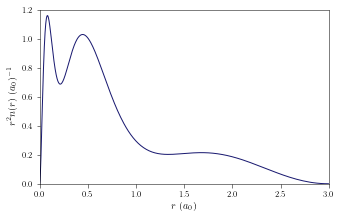

In [5]:
# extract the density object
dens_Al = output["density"]

# General figure set-up                                                                                                                                                                                        
figdims = MIS_plots.fig_initialize(latex=True, setsize=True,fraction=0.8)
fig, ax = plt.subplots(1, 1, figsize=(figdims))

# get the total density and grid
dens_tot = dens_Al.total[0]
xgrid = dens_Al._xgrid  # log grid
rgrid = np.exp(xgrid)  # radial grid

# plot the total density
ax.plot(rgrid, rgrid ** 2 * dens_tot,color='midnightblue')

# some formatting
ax.set_xlim(0, 3)
ax.set_ylim(0, 1.2)
ax.set_xlabel(r"$r\ (a_0)$")
ax.set_ylabel(r"$r^2 n(r)\ (a_0)^{-1}$")
plt.savefig("/home/callow46/mean_ionization_paper/figures/density_example.pdf")

## Convergence testing

There are various parameters which should be checked for convergence. For all the boundary conditions, the main ones are:

* `nmax`: the maximum number of the principal quantum number $n$
* `lmax`: the maximum number of the angular quantum number $l$
* `grid_params`: dictionary parameter controlling the logarithmic grid, in particular the number of grid points `ngrid`

Furthermore, for the `bands` boundary condition, there is the additional dictionary parameter `band_params`. The important property within this is `nkpts` number of 'k' points, which is the number of states that are computed within all energy bands (spaced linearly in energy) in our model.

The convergence for the `nmax` and `lmax` paramaters can generally be chosen by eye, in other words by ensuring there are sufficient states such that the highest levels have (nearly) zero occoupations. Let us consider our Aluminium atom from earlier, but now we shall increase the temperature (so more orbitals are required).

In [6]:
# set the temperature to 10 eV
Al_atom.units_temp = "eV"
Al_atom.temp = 10

# run the calculation again
output = Al_model.CalcEnergy(nmax, lmax, write_info=True)

Starting SCF energy calculation
 
iscf   E_free (Ha)    dE (1.0e-05)   dn (1.0e-04)   dv (1.0e-04)
-----------------------------------------------------------------
   0   -214.2613678      1.000e+00      9.999e-01      1.000e+00
   1   -224.1287430      4.403e-02      1.020e+00      7.395e-01
   2   -237.0838124      5.464e-02      8.010e-01      4.294e-01
   3   -242.4343199      2.207e-02      2.026e-01      6.883e-02
   4   -242.5475915      4.670e-04      3.594e-02      1.508e-02
   5   -242.5491121      6.269e-06      3.520e-03      6.318e-03
   6   -242.5492575      5.992e-07      1.319e-03      2.665e-03
   7   -242.5492674      4.081e-08      4.664e-04      1.134e-03
   8   -242.5492662      4.693e-09      1.654e-04      4.839e-04
   9   -242.5492654      3.390e-09      5.894e-05      2.061e-04
  10   -242.5492651      1.177e-09      2.111e-05      8.756e-05
-----------------------------------------------------------------
SCF cycle converged
 
Final energies (Ha)
 
----------

In the above example, we see that `nmax=5` seems to be sufficiently large, but `lmax=3` is not, because the occupation of the $l=2,n=0$ state is 0.834, i.e. significantly above zero. We therefore choose a much larger value of `lmax` to check what is required for convergence. 

Since the diagonalization must be performed separately for every value of $0\leq l<\textrm{lmax}$, the computational time is proportional to `lmax`. There is a simple kind of parallelization implemented in atoMEC, courtesy of the joblib library \cite{joblib}, which parallelizes the calculation over `l` (and also spin if `model.spinpol=True`) and thus makes calculations more efficient. This is enabled by the `config.numcores` parameter. Setting `config.numcores=n` uses `n` cores; however, it is often easiest to set `config.numcores=-1` which uses all the available cores.

In [7]:
# enable parallelization
from atoMEC import config
config.numcores = -1

# re-run the calculation with larger lmax
lmax = 10
output = Al_model.CalcEnergy(nmax, lmax)

Starting SCF energy calculation
 
iscf   E_free (Ha)    dE (1.0e-05)   dn (1.0e-04)   dv (1.0e-04)
-----------------------------------------------------------------
   0   -214.2614028      1.000e+00      9.999e-01      1.000e+00
   1   -223.8611104      4.288e-02      1.026e+00      7.419e-01
   2   -237.0092438      5.548e-02      8.081e-01      4.366e-01
   3   -242.4583678      2.247e-02      2.045e-01      7.008e-02
   4   -242.5739606      4.765e-04      3.631e-02      1.562e-02
   5   -242.5755082      6.380e-06      3.613e-03      6.216e-03
   6   -242.5765476      4.285e-06      1.354e-03      2.643e-03
   7   -242.5765568      3.801e-08      4.785e-04      1.126e-03
   8   -242.5765553      6.434e-09      1.698e-04      4.806e-04
   9   -242.5765537      6.366e-09      6.023e-05      1.107e-04
  10   -242.5765539      8.793e-10      2.205e-05      2.183e-04
  11   -242.5765064      1.961e-07      1.944e-05      3.995e-04
  12   -242.5765539      1.960e-07      1.930e-05      

In the above, we clearly see that `lmax=10` is more than sufficient; in fact, it seems that `lmax=6` is enough in this case. Next, we shall test the convergence with respect to the number of grid points. We suppress the output from the SCF cycle since we shall run several calculations. If you are running this notebook, be patient as running all the calculations will take some time.

In [8]:
# set up the grid points to test over
ngrid_test = np.arange(500, 4500, 500)

# set up array to store the total energy, 1s core energy and chemical potential
output_arr = np.zeros((len(ngrid_test), 4))

# reset lmax to 6
lmax = 6

# change into the converence directory
os.chdir(basedir + "/convergence_tests/")
# loop over the ngrid array
for i, ngrid in enumerate(ngrid_test):
    # set the output to an external file
    sys.stdout = open("Al_ngrid_" + str(ngrid) + ".log", "w")
    output = Al_model.CalcEnergy(
        nmax, lmax, grid_params={"ngrid": ngrid}, write_info=False
    )
    output_arr[i, 0] = ngrid
    output_arr[i, 1] = output["energy"].F_tot
    output_arr[i, 2] = output["orbitals"].eigvals[0, 0, 0, 0]
    output_arr[i, 3] = config.mu

os.chdir(basedir) # change back to base directory
sys.stdout = default_stdout # change output back to console

We tabulate the total energy, core $1s$ energy level and chemical potential $\mu$ below to check their convergence with respect to the grid size.

In [9]:
# import package to make nice tables
import tabulate

# define table headings
headers = ["ngrid", "F tot", "e_1s", "mu"]

# create table
conv_tbl = tabulate.tabulate(
    output_arr,
    headers,
    tablefmt="presto",
    floatfmt=["4.0f", "7.3f", "7.3f", "7.3f"],
    stralign="right",
)
print(conv_tbl)

   ngrid |    F tot |    e_1s |      mu
---------+----------+---------+---------
     500 | -243.265 | -54.713 |   0.189
    1000 | -242.577 | -54.624 |   0.219
    1500 | -242.345 | -54.595 |   0.229
    2000 | -242.229 | -54.580 |   0.235
    2500 | -242.159 | -54.572 |   0.238
    3000 | -242.113 | -54.566 |   0.240
    3500 | -242.080 | -54.562 |   0.241
    4000 | -242.055 | -54.559 |   0.242


The degree of convergence required depends on various factors, such as the error that the user is willing to tolerate and the property that is being computed. In AA models, there are already a number of quite serious approximations which create uncertainty in the results, so typically we can use more relaxed convergence criteria than a full DFT-MD simulation. The property we are interested in for the purposes of this paper is the MIS, which is sensitive to the energy eigenvalues and chemical potential but not the total energy. Furthermore, we aim to benchmark our results agaist experiments which of course have some uncertainty for measurements of the free electron density.

With the above factors taken into account, we typically aim for convergence of around $0.01\ \textrm{Ha}$ in the core $1s$ energy level and the chemical potential $\mu$. Based on the above table, this indicates a reasonable choice is `ngrid=3000`. In theory, this number should be checked for each value of temperature and density calculated. In practise, it is reasonable to test it for a few select values in the temperature or density range spanned and interpolate to the other values.

As mentioned, when the `bands` boundary condition is used, we must also test convergence with respect to the number of orbitals `nkpts` per band. We perform a similar convergence check to before, only now we shall we probe the lowest energy eigenvalue in the conduction band, instead of the $1s$ core energy level. This is because, under these conditions, the $1s$ level is fully isolated from the neighbouring spheres and so is not part of an energy band.

In [10]:
# set up the nkpts array
nkpts_arr = np.arange(10, 110, 10)

# change the boundary condition
Al_model.bc = "bands"

# reset the output array
output_arr = np.zeros((len(nkpts_arr), 4))

# change to convergence directory
os.chdir(basedir + "/convergence_tests/")
# loop over the nkpts array with a coarse ngrid value (independent)
for i, nkpts in enumerate(nkpts_arr):
    # set the output to an external file
    sys.stdout = open("Al_nkpts_" + str(ngrid) + ".log", "w")
    output = Al_model.CalcEnergy(
        nmax,
        lmax,
        grid_params={"ngrid": 1000},
        write_info=False,
        band_params={"nkpts": nkpts},
    )
    output_arr[i, 0] = nkpts
    output_arr[i, 1] = output["energy"].F_tot
    output_arr[i, 2] = output["orbitals"].eigvals[0, 0, 0, 2]
    output_arr[i, 3] = config.mu
    
os.chdir(basedir) # change back to base directory
sys.stdout = default_stdout # change output back to console

In [11]:
# create table
headers = ["nkpts", "F tot", "e_c", "mu"]
conv_tbl = tabulate.tabulate(
    output_arr,
    headers,
    tablefmt="presto",
    floatfmt=["4.0f", "7.3f", "7.3f", "7.3f"],
    stralign="right",
)
print(conv_tbl)

   nkpts |    F tot |     e_c |      mu
---------+----------+---------+---------
      10 | -243.814 |  -0.131 |  -0.038
      20 | -243.859 |  -0.130 |  -0.053
      30 | -243.869 |  -0.130 |  -0.057
      40 | -243.873 |  -0.130 |  -0.058
      50 | -243.875 |  -0.130 |  -0.059
      60 | -243.877 |  -0.130 |  -0.059
      70 | -243.878 |  -0.130 |  -0.059
      80 | -243.878 |  -0.129 |  -0.059
      90 | -243.879 |  -0.130 |  -0.060
     100 | -243.879 |  -0.130 |  -0.060


We see from the above that, for this example, the quantities of interest are very well converged already with `nkpts=20`. However, the time taken is almost identical regardless of the number of $k$-points used. This is because the computationally dominant step is actually the diagonalization of the Hamiltonian, which is required to find the limits of the band energies. Therefore we are free to choose a relatively large value of `nkpts` without much affect on the computational demands. Typically the default value of `nkpts=50` in atoMEC is a reasonable choice. 

# Density-of-states for Carbon with AA model

We shall now calculate and plot the DOS for Carbon using the band-structure AA model under a range of densities, for temperature $T=100\ \textrm{eV}$. The conditions we use are identical to those considered in Ref. \onlinecite{Redmer_Kubo_Greenwood}, in order to facilitate comparison between the AA model and a full DFT-MD simulation.

First, we calculate the DOS for Carbon under these conditions:

In [12]:
# set up the base Carbon atom
C_atom = Atom("C", 100, density=1.0, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(C_atom, unbound="quantum", bc="bands", write_info=False)
# define the densities
densities = np.array([20, 30, 50, 80, 100, 150, 200, 300, 400], dtype=float)
# set up empty array of chemical potentials
chem_pots = np.zeros_like(densities)
# set the lmax and nmax parameters
lmax = 10
nmax = 10
# grid parameters
grid_params = {"ngrid": 2000}
# band parameters
band_params = {"nkpts": 50}

# change into the bc directory
os.chdir(basedir + "/results/Carbon/bands/")
for i, density in enumerate(densities):
    # set the output to an external file
    sys.stdout = open("C_" + str(density) + ".log", "w")
    # set the density
    C_atom.density = density
    # run the SCF calculation
    output = model.CalcEnergy(
        nmax,
        lmax,
        grid_params=grid_params,
        band_params=band_params,
        dos_file="dos_" + str(density) + ".csv",
    )
    # save the chemical potential
    chem_pots[i] = config.mu

os.chdir(basedir) # change back to base directory
sys.stdout = default_stdout # change output back to console

Next, we plot the DOS:

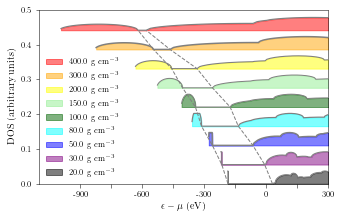

In [13]:
import MIS_plots
MIS_plots.plot_DOS(densities, chem_pots)

Note that, for the densities between $20-80\ \textrm{g cm}^{-3}$, we have truncated the peak of the part of the DOS that comes from the valence ($1s$) band, because the band width approaches zero and thus the DOS approaches a delta function. Nevertheless, the figure shows strong qualitative agreeement with the equivalent Fig. 2 in Ref. \onlinecite{Redmer_Kubo_Greenwood}; furthermore, the position and width of the band gap is in quantitative agreement. This indicates the band-structure AA model is a good approximation for the full DFT-MD simulation under the above conditions.

# Mean ionization state comparisons

In the previous section, we introduced the basics of running a calculation in atoMEC to compute various quantities such as the KS orbitals and the density. In this section, we explain how to compute the MIS in atoMEC via the various methods described in the paper. Afterwards, we provide the input (and output) for the calculations that were done in the paper, so that the reader can reproduce these results.

## Calculation of MIS using the threshold method

As seen in Eq. (1) of the main paper, the MIS can be computed as the integral over all the positive energy states:

\begin{equation}
\bar{Z} = \int_{v(R_\textrm{WS})}^\infty g(\epsilon) f_\textrm{FD}(\epsilon)\,,
\end{equation}

where $g(\epsilon)$ is the density-of-states (DOS), $f_\textrm{FD}(\epsilon)$ the Fermi--Dirac distribution, and $v(R_\textrm{WS})$ the value of the potential at the Wigner--Seitz (WS) radius.

In atoMEC, when `unbound="quantum"`, all the orbitals are treated identically. The integral in the above equation therefore becomes a sum over all the states with energies above $v(R_\textrm{WS})$,

\begin{equation}
\bar{Z} = 2\sum_{k,\sigma,l,n} (2l+1) w_{k} f_{k ln} \Theta(\epsilon_{k ln}-v(R_\textrm{WS}))\,,
\end{equation}

where $\Theta$ is the Heaviside step function.

As was seen in the earlier examples, the MIS calculate via the threshold method is printed by default at the end of every SCF run anyway. It is also a property of the `staticKS.Density` object so can be accessed through that if desired. Let us again run a calculation for Aluminium at ambient conditions:

In [14]:
# first set up and run a calculation
# set up the ISModel
Al_model = models.ISModel(
    Al_atom,
    bc="dirichlet",
    unbound="quantum",
    xfunc_id="lda_x",
    cfunc_id="lda_c_pw",
    write_info=False,
)

# reset temperature and density
Al_atom.temp = 0.01
Al_atom.density = 2.7

# set the values of nmax and lmax
nmax = 5
lmax = 3

# run the SCF calculation
output = Al_model.CalcEnergy(
    nmax,
    lmax,
    scf_params={"mixfrac": 0.6, "maxscf": 50},
    grid_params={"ngrid": 2000},
    write_info=False,
)

Normal temperature range for atoMEC is 0.01 -- 100 eV 

func:'CalcEnergy' took: 28.6349 sec


In [15]:
# extract the MIS
MIS = output["density"].MIS

# print the 1st array element (only element in a spin unpolarized calculation)
print("MIS = ", round(MIS[0], 2))

MIS =  3.0


In this case, the MIS computed with the threshold approach is equal to $3.0$, which is the number of orbitals in the conduction band for Aluminium at ambient conditions.

## Calculation of MIS using the electron localization function

As seen in Eq. (4) of the main paper, the electron localization function (ELF) is defined as

\begin{gather}
\textrm{ELF}(r) = \frac{1}{1+[D(\vec{r})/D_0(\vec{r})]^2}\,,\textrm{ with} \\
D(\vec{r}) = D_0(\vec{r}) - \frac{1}{9} \frac{|\nabla n(\vec{r})^2|}{n(\vec{r})} + \frac{1}{6}\nabla^2 n(\vec{r})\,, \textrm{ and} \\
D_0(\vec{r}) = \frac{3}{10}(3\pi^2)^{2/3} n^{5/3}(r)\,.
\end{gather}

For a spherically symmetric system, $D_0(r)=D_0(\vec{r})$ and the expression for $D(r)$ becomes

\begin{equation}
D(r) = D_0(r) - \frac{1}{9} \frac{1}{n(r)} \left| \frac{\textrm{d}n(r)}{\textrm{d}r}\right|^2 + \frac{1}{6} \left(  \frac{2}{r} \frac{\textrm{d}n(r)}{\textrm{d}r} +  \frac{\textrm{d}^2 n(r)}{\textrm{d}r^2}\right)\,.
\end{equation}

In atoMEC the ELF is accessed through the `postprocess.localization` module. In the following, we calculate and plot the ELF for our Aluminium example. 

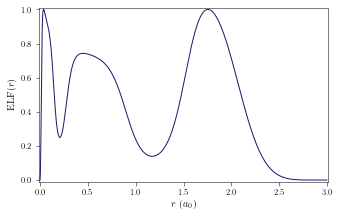

In [16]:
# import localization module
from atoMEC.postprocess import localization

# Set up the ELF object
# use the "density" version of the ELF (uses second order gradient expansion for KED)

ELF_Al = localization.ELFTools(output["orbitals"], output["density"], method="density")
xgrid = ELF_Al._xgrid
rgrid = np.exp(xgrid)

# extract the ELF function
ELF_func = ELF_Al.ELF

# General figure set-up                                                                                                                                                                                        
figdims = MIS_plots.fig_initialize(latex=True, setsize=True,fraction=0.8)
fig, ax = plt.subplots(1, 1, figsize=(figdims))

# plot the ELF function
ax.plot(rgrid, ELF_func[0],color="midnightblue")

ax.set_xlim(-0.01, 3.01)
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(r"$r\ (a_0)$")
ax.set_ylabel(r"ELF$(r)$")
plt.savefig("/home/callow46/mean_ionization_paper/figures/ELF_example.pdf")

The next stage is to use the ELF to compute the number of electrons in a given shell. This is done by finding the positions of the minima of the ELF, and integrating the density between them, as explained in the main paper. In atoMEC, we can access this data from the `N_shell` property of the `ELFTools` object:

In [17]:
# extract the number of electrons per shell
N_s = ELF_Al.N_shell[0]

for i in range(len(N_s)):
    print("The number of electrons in the n =", i + 1, "shell =", round(N_s[i], 2))

The number of electrons in the n = 1 shell = 2.13
The number of electrons in the n = 2 shell = 7.72
The number of electrons in the n = 3 shell = 3.11


These numbers approximately match up to what we expect from ambient Aluminium: 2 electrons in the $n=1$ shell, 8 in the $n=2$ shell, and the remaining 3 electrons in the conduction band (which we call the $n=3$ shell here). As discussed in the main paper, extracting the MIS from this output requires some user input based on physical intuition, to decide which shells should be counted as bound and which free.

## Calculation of the MIS using the Kubo--Greenwood formula

As seen in eq. (2) of the main text, the KG conductivity formula in a finite system is given by

\begin{equation}
\sigma_{S_1,S_2} (\omega)= \frac{2\pi}{3V\omega} \sum_{i\in S_1} \sum_{j\in S_2} (f_i - f_j) |\langle \phi_i | \nabla | \phi_j \rangle|^2 \delta (\epsilon_j - \epsilon_i - \omega)\,,
\end{equation}

for subsets $\{S_1\},\{S_2\}$ of the orbitals. In the spherically symmetric case, this becomes

\begin{equation}
\sigma_{S_1,S_2}(\omega) = \frac{2\pi}{3V\omega} \sum_{nlm\in S_1} \sum_{n'l'm'\in S_2} (f_{nlm} - f_{n'l'm'}) |\langle \phi_{nlm} | \nabla | \phi_{n'l'm'} \rangle|^2 \delta (\epsilon_{n'l'm'} - \epsilon_{nlm} - \omega)\,.
\end{equation}

Note that, in the band-structure model, this becomes

\begin{equation}
\sigma_{S_1,S_2} (\omega) = \frac{2\pi}{3V\omega} \sum_k w_k \sum_{nlm\in S_1} \sum_{n'l'm'\in S_2} (f_{knlm} - f_{kn'l'm'}) |\langle \phi_{knlm} | \nabla | \phi_{kn'l'm'} \rangle|^2 \delta (\epsilon_{kn'l'm'} - \epsilon_{knlm} - \omega)\,,
\end{equation}

similar to the KG conductivity in plane-wave DFT codes. For simplicity, and because in the end we shall only the KG conductivity with the Dirichlet boundary condition, we shall present the equations without the $k$-index. Since the summation only involves orbitals with the same $k$-value, it is straightforward to re-introduce this at the end of the derivation.

We focus first on the integral component of the equation for $\sigma(\omega)$, which is given by

\begin{align}
|\langle \phi_{knlm} | \nabla | \phi_{kn'l'm'} \rangle|^2 &= \sum_{i=1}^3 \langle \phi_{knlm} | \nabla_i | \phi_{kn'l'm'} \rangle \langle \phi_{kn'l'm'} | \nabla_i | \phi_{knlm} \rangle \\
&=3 \langle \phi_{knlm} | \nabla_z | \phi_{kn'l'm'} \rangle \langle \phi_{kn'l'm'} | \nabla_z | \phi_{knlm} \rangle\,,
\end{align}

where the second equation follows because the contribution from each cartesian component of the gradient is identical in spherically symmetric systems. We choose the $z$ component because, in the traditional transformation between cartesian and spherical co-ordinates, this leads to a simpler set of equations. Let us now focus on the following term,

\begin{align}
\langle \phi_{kn'l'm'} | \nabla_z | \phi_{knlm} \rangle&= \nabla_{nn'll'mm'}^z \\
&=R^{(d)}_{nn'll'} P^{(2)}_{lml'm'} \delta_{mm'} + R_{nn'll'} P^{(4)}_{lml'm'} \delta_{mm'},
\end{align}

which has been taken from this Ref. \onlinecite{Trickey_Kubo_Greenwood}. We do not derive the above expression, but instead direct readers to the aforementioned paper where it is derived in full. The terms in the above expression are given by

\begin{align}
R^{(d)}_{nn'll'} &= 4\pi\int_0^{R_\textrm{VS}} \textrm{d}r r^2 X_{n'l'}(r) \frac{\textrm{d}X_{nl}(r)}{\textrm{d}r}\\
 R_{nn'll'} &= 4\pi\int_0^{R_\textrm{VS}} \textrm{d}r r X_{n'l'}(r) X_{nl}(r) \\
 P^{(2)}_{lml'm'} &= 2\pi C_{lm}C_{l'm'} \int_{-1}^{1} \textrm{d}x x P_{l'}^{m'} (x) P_{l}^{m}(x) \\
 P^{(4)}_{lml'm'} &= -2\pi C_{lm}C_{l'm'} \int_{-1}^{1} \textrm{d}x (1-x^2) P_{l'}^{m'} (x) \frac{\textrm{d}P_l^m(x)}{\textrm{d}x}\\
 C_{lm} &= \sqrt{\frac{2l+1}{4\pi}}\sqrt{\frac{(l-|m|)!}{(l+|m|)!)}}\,,
\end{align}

where $P_l^m(x)$ are the Legendre polynomials. Note there are some additional factors of $4\pi$ in the above expressions compared to Ref. \onlinecite{Trickey_Kubo_Greenwood}, due to different conventions in normalization of the orbitals. Returning to the expression for $\sigma(\omega)$, we now have

\begin{equation}
\sigma_{S_1,S_2}(\omega) = \frac{2\pi}{V\omega} \sum_{nl\in S_1} \sum_{n'l'\in S_2} \sum_{m\in \{S1,S2\}} (f_{nl} - f_{n'l'}) |\nabla_{nn'll'm}^z|^2 \delta (\epsilon_{n'l'} - \epsilon_{nl} - \omega) \delta(l\pm 1 - l')\,.
\end{equation}

In the above, the double summation over $m$ has been reduced to a single summation because of the presence of the the $\delta_{mm'}$ in $\nabla_{nn'll'mm'}^z$. Additionally, the $\delta(l\pm 1 - l')$ comes from sum rules in the evaluation of the $P^{(2,4)}$ integrals.

Now, noting the relationship between the conductivity and the number of electrons $Z_{S1,S2}$ which contribute to that part of the conductivity,

\begin{equation}
Z_{S1,S2} = \frac{2V}{\pi} \int_0^\infty \textrm{d}\omega \sigma_{S1,S2}(\omega)\,, 
\end{equation}

we substitute our AA conductivity formula into the above expression to obtain

\begin{equation}
Z_{S1,S2} = 4 \sum_{nl\in S_1} \sum_{n'l'\in S_2} \sum_{m\in \{S1,S2\}} \frac{f_{nl} - f_{n'l'}}{\epsilon_{n'l'}-\epsilon_{nl}}|\nabla_{nn'll'm}^z|^2 \delta(l\pm 1 - l') \Theta (\epsilon_{n'l'}-\epsilon_{nl})
\end{equation}

In a conventional AA model, unlike in plane-wave DFT calculations, there is no concept of a band-structure, which might seem problematic for determining which subset of orbitals belong to the conducting vs valence bands. However, we have found that using the chemical potential $mu$ to divide the orbitals into conduction and valence subsets tends to be consistent with manual inspection of the DOS with the band-structure AA model, and as we shall see, yields good results.

In atoMEC the Kubo--Greenwood functionality is accessed through the `kubo_greenwood` module. We show how to extract the total number of electrons (to check the sum rule is satisfied) and the number of free electrons (i.e. the MIS) below.

In [18]:
# first we re-run the Al calculation with more unoccupied orbitals
# this is required because the KG method needs empty orbitals to converge

# set the values of nmax and lmax
nmax = 25
lmax = 10

# run the SCF calculation
output = Al_model.CalcEnergy(
    nmax,
    lmax,
    scf_params={"mixfrac": 0.6, "maxscf": 50},
    grid_params={"ngrid": 2000},
    write_info=False,
)

func:'CalcEnergy' took: 68.8155 sec


In [19]:
# we need to define the 'valence' orbitals, which actually means everything not in the conduction band
# for solid Al at room temperature the valence orbitals are 1s, 2s and 2p
valence_orbs = [(0, 0), (1, 0), (0, 1)]

# set up the Kubo-Greenwood object
kg = localization.KuboGreenwood(output["orbitals"], valence_orbs=valence_orbs)

# compute the total number of electrons
N_tot = kg.N_tot

# compute the number of free electrons
N_free = kg.N_free

# print the output
print("Total number of electrons = ", round(N_tot, 2))
print("Number of free electrons = ", round(N_free, 2))

Total number of electrons =  12.95
Number of free electrons =  3.29


In the above example, it can be seen that the total number of electrons equals 12.95, which is very close to the expected value of 13 for Alunimium (less than 1\% difference). Therefore it seems the values of `nmax` and `lmax` are large enough for the KG calculation to be converged. The number of free electrons is 3.29, which is close to the value of 3 that might be expected from physical intuition.

# Results

In this section, we run through the calculations presented in the paper. In the first sub-section, we run the SCF calculations to get the KS orbitals and density. These are used as inputs for computing the MIS via the different methods, which we run through in the following sub-section. Note that the primary objective of atoMEC is not computationally efficiency, and thus the each SCF calculation may take up to ~20 minutes for the inputs used in the paper. If you wish to run all the SCF calculations, we provide all necessary inputs but we suggest to run the calculations on a separate cluster.


## SCF calculations: Carbon

In you wish to run the SCF calculations, please set `run_SCF_calcs = True` below:

In [20]:
# whether to run the SCF calculations
run_SCF_calcs = False

First, we set up the calculations for Carbon at $T=100$ eV, under a range of densities.

In [21]:
import pickle as pkl

# ensure parallelism is on
config.numcores = 9
# set up the base Carbon atom
C_atom = Atom("C", 100, density=1.0, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(C_atom, unbound="quantum", write_info=False)
# define the boundary conditions
bcs = ["dirichlet", "neumann", "bands"]
# define the densities
densities = np.array([1, 2, 5, 10, 20, 50, 80, 100, 150, 200, 300, 400], dtype=float)
# set the lmax parameter (same for all bcs)
lmax = 20
# grid parameters
grid_params = {"ngrid": 3000}
# band_parameters
band_params = {"nkpts": 50}
# base directory
basedir = "/home/callow46/mean_ionization_paper"

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Carbon/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 30
        else:
            nmax = 20
        # loop over the densities
        for density in densities:
            # set the output to an external file
            sys.stdout = open("C_" + str(density) + ".log", "w")
            # set the density
            C_atom.density = density
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params=band_params,
                dos_file="dos_" + str(density) + ".csv",
            )
            # save the orbitals and density output
            orbfile = "C_orbs_" + str(density) + ".pkl"
            densfile = "C_dens_" + str(density) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f)
                
# reset output to terminal
sys.stdout = default_stdout

## SCF calculations: Beryllium

Next, we set up the calculations for Beryllium with fixed density $\rho_\textrm{m} = 1.85\ \textrm{g cm}^{-3}$, for a range of temperatures.

In [22]:
# set up the base Beryllium atom
Be_atom = Atom("Be", 1, density=1.85, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Be_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(2, 86, 4, dtype=float)
# set the lmax parameter (same for all bcs)
lmax = 15
# grid parameters
grid_params = {"ngrid": 3000}

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Beryllium/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 30
        else:
            nmax = 15
        if bc == "bands":
            nkpts = 50
        else:
            nkpts = 1
        # loop over the densities
        for temp in temps:
            # set the output to an external file
            sys.stdout = open("Be_" + str(temp) + ".log", "w")
            # set the density
            Be_atom.temp = temp
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params={"nkpts": nkpts},
            )
            # save the orbitals and density output
            orbfile = "Be_orbs_" + str(temp) + ".pkl"
            densfile = "Be_dens_" + str(temp) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f, protocol=pkl.HIGHEST_PROTOCOL)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f, protocol=pkl.HIGHEST_PROTOCOL)

# reset output to terminal
sys.stdout = default_stdout

## SCF calculations: Aluminium (i)

We first run the necessary SCF calculations for the first Aluminium experiment, for which the density is fixed at $2.7 \textrm{g cm}^{-3}$ and the temperature is varied between 10 and 30 eV.

In [23]:
# set up the base Aluninium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Al_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(10, 36, 1, dtype=float)
# grid parameters
grid_params = {"ngrid": 3000}

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Aluminium/expt_comp_1/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 30
            lmax = 20
        else:
            nmax = 10
            lmax = 15
        if bc == "bands":
            nkpts = 50
        else:
            nkpts = 1
        # loop over the densities
        for temp in temps:
            # set the output to an external file
            sys.stdout = open("Al_" + str(temp) + ".log", "w")
            # set the density
            Al_atom.temp = temp
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params={"nkpts": nkpts},
            )
            # save the orbitals and density output
            orbfile = "Al_orbs_" + str(temp) + ".pkl"
            densfile = "Al_dens_" + str(temp) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f, protocol=pkl.HIGHEST_PROTOCOL)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f, protocol=pkl.HIGHEST_PROTOCOL)
            

# reset output to terminal
sys.stdout = default_stdout

## SCF calculations: Aluminium (ii)

We first run the necessary SCF calculations for the first Aluminium experiment, for which the density is fixed at $2.7\ \textrm{g cm}^{-3}$ and the temperature is varied between 0 and 100 eV. Because we span a wider range of temperatures in this run compared to the last, we need to use larger values of `nmax` and `lmax` to include more orbitals.

In [24]:
# no need to re-define the atom or model this time
# define the temperatures
temps = np.arange(0, 105, 5, dtype=float)
temps[0] = 0.01  # redefine so we don't have zero temperature
# grid parameters
grid_params = {"ngrid": 3000}
# universal lmax
lmax = 20

if run_SCF_calcs:
    # loop over boundary conditions
    for bc in bcs:
        # change into the bc directory
        os.chdir(basedir + "/results/Aluminium/expt_comp_2/" + bc + "/")
        # set the boundary condition
        model.bc = bc
        # dirichlet needs more eigenvalues since empty states required for Kubo-Greenwood
        if bc == "dirichlet":
            nmax = 40
        else:
            nmax = 20
        if bc == "bands":
            nkpts = 50
        else:
            nkpts = 1
        # loop over the densities
        for temp in temps:
            # set the output to an external file
            sys.stdout = open("Al_" + str(temp) + ".log", "w")
            # set the density
            Al_atom.temp = temp
            # run the SCF calculation
            output = model.CalcEnergy(
                nmax,
                lmax,
                grid_params=grid_params,
                band_params={"nkpts": nkpts},
            )
            # save the orbitals and density output
            orbfile = "Al_orbs_" + str(temp) + ".pkl"
            densfile = "Al_dens_" + str(temp) + ".pkl"
            with open(orbfile, "wb") as f:
                pkl.dump(output["orbitals"], f, protocol=pkl.HIGHEST_PROTOCOL)
            with open(densfile, "wb") as f:
                pkl.dump(output["density"], f, protocol=pkl.HIGHEST_PROTOCOL)

# reset output to terminal
sys.stdout = default_stdout

## Mean ionization state calculations: Carbon

We now proceed to compute the MIS via the three methods discussed. As mentioned, both the ELF and KG methods need some user-defined input to determine which orbitals should be treated as bound vs free (for the ELF method), or conduction or valence vs conduction (for the KG method). For Carbon under the conditions we probe, we take the $1s$ orbital (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in this band (i.e. the $n=1$ principle quantum level) is bound and that the remaining electron density is free.

In [25]:
# set up the base Carbon atom
C_atom = Atom("C", 100, density=1.0, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(C_atom, unbound="quantum", write_info=False)
# define the boundary conditions
bcs = ["dirichlet", "neumann", "bands"]
# define the densities
densities = np.array([1, 2, 5, 10, 20, 50, 80, 100, 150, 200, 300, 400], dtype=float)
# base directory
basedir = "/home/callow46/mean_ionization_paper"

# set up empty MIS arrays
MIS_thresh = np.zeros((len(densities),4))
MIS_ELF = np.zeros((len(densities),4))
MIS_kg = np.zeros((len(densities),3))
MIS_thresh[:, 0] = densities
MIS_ELF[:, 0] = densities
MIS_kg[:, 0] = densities

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Carbon/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the densities
    for j, density in enumerate(densities):
        # save the orbitals and density output
        orbfile = "C_orbs_" + str(density) + ".pkl"
        densfile = "C_dens_" + str(density) + ".pkl"        
        C_atom.density = density
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        # set up input params        
        config.band_params["nkpts"], config.spindims, config.lmax, config.nmax = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - N_ub_shell[0]
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = localization.KuboGreenwood(orbs, valence_orbs=[(0,0)])
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free
    
# save the results
os.chdir(basedir + "/results/Carbon/")
header=("Density (g/cm^3), Z (dirichlet), Z (Neumann), Z (bands)")
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt='%8.4f', header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt='%8.4f', header=header, delimiter=",")
header=("Density (g/cm^3), N total, Z (dirichlet)")
np.savetxt("MIS_kg.csv", MIS_kg, fmt='%8.4f', header=header, delimiter=",")

/home/callow46/atoMEC/atoMEC/postprocess/localization.py:212: RuntimeWarning: divide by zero encountered in true_divide
  epdc = D_0 - (grad_dens) ** 2.0 / (9.0 * density) + lap_dens / 6.0


The results of the MIS calculations can be examined using the `csv` files saved in the above code.

## Mean ionization state calculations: Beryllium

For Beryllium under the conditions we probe, we take the $1s$ orbital (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in this band (i.e. the 𝑛=1 principle quantum level) is bound and that the remaining electron density is free.

In [26]:
# set up the base Beryllium atom
Be_atom = Atom("Be", 1, density=1.85, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Be_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(2, 86, 4, dtype=float)

# set up empty MIS arrays
MIS_thresh = np.zeros((len(temps),4))
MIS_ELF = np.zeros((len(temps),4))
MIS_kg = np.zeros((len(temps),3))
MIS_thresh[:, 0] = temps
MIS_ELF[:, 0] = temps
MIS_kg[:, 0] = temps

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Beryllium/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the temperatures
    for j, temp in enumerate(temps):
        # set the temperature
        Be_atom.temp = temp
        # load the orbitals and density output
        orbfile = "Be_orbs_" + str(temp) + ".pkl"
        densfile = "Be_dens_" + str(temp) + ".pkl"
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)      
        # set up input params        
        config.band_params["nkpts"], config.spindims, config.lmax, config.nmax = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - N_ub_shell[0]
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = localization.KuboGreenwood(orbs, valence_orbs=[(0,0)])
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free
    
# save the results
os.chdir(basedir + "/results/Beryllium/")
header=("Temperature (eV), Z (dirichlet), Z (Neumann), Z (bands)")
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt='%8.4f', header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt='%8.4f', header=header, delimiter=",")
header=("Temperature (eV) , N total, Z (dirichlet)")
np.savetxt("MIS_kg.csv", MIS_kg, fmt='%8.4f', header=header, delimiter=",")

The results of the MIS calculations can be examined using the `csv` files saved in the above code. 

To convert from the MIS to the free electron density, one can use the expression $n_\textrm{f} = (Z / N_\textrm{e}) * n_\textrm{e}$, where $n_\textrm{e}$ is the total electron density, and $N_\textrm{e}$ the total electron number. The total electron density (in cm$^{-3}$) is given by

In [29]:
# compute the volume in cm^3
from atoMEC import unitconv
radius_cm = Be_atom.radius * 1e-8 / unitconv.angstrom_to_bohr
Be_vol = (4/3) * np.pi * radius_cm**3
n_e =  Be_atom.nele / Be_vol
print("Total electron density per cm^3 = {n_e:7.3e}".format(n_e = n_e))

Total electron density per cm^3 = 4.909e+23


## Mean ionization state calculations: Aluminium (i)

For Aluminium under the conditions we probe, we take the $1𝑠,\ 2s,\ \textrm{and}\ 2p$ orbitals (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in the $n=1$ and $n=2$ principle quantum levels is bound and that the remaining electron density is free.

In [27]:
# set up the base Aluninium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Al_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(10, 36, 1, dtype=float)
# set up empty MIS arrays
MIS_thresh = np.zeros((len(temps),4))
MIS_ELF = np.zeros((len(temps),4))
MIS_kg = np.zeros((len(temps),3))
MIS_thresh[:, 0] = temps
MIS_ELF[:, 0] = temps
MIS_kg[:, 0] = temps

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Aluminium/expt_comp_1/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the temperatures
    for j, temp in enumerate(temps):
        # set the temperature
        # load the orbitals and density output
        orbfile = "Al_orbs_" + str(temp) + ".pkl"
        densfile = "Al_dens_" + str(temp) + ".pkl"
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        # set up input params        
        config.band_params["nkpts"], config.spindims, config.lmax, config.nmax = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - (N_ub_shell[0] + N_ub_shell[1])
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = localization.KuboGreenwood(orbs, valence_orbs=[(0,0), (0,1), (1,0)])
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free
    
# save the results
os.chdir(basedir + "/results/Aluminium/expt_comp_1")
header=("Temperature (eV), Z (dirichlet), Z (Neumann), Z (bands)")
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt='%8.4f', header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt='%8.4f', header=header, delimiter=",")
header=("Temperature (eV), N total, Z (dirichlet)")
np.savetxt("MIS_kg.csv", MIS_kg, fmt='%8.4f', header=header, delimiter=",")

The results of the MIS calculations can be examined using the `csv` files saved in the above code. To convert from the MIS to the free electron density, the following code can be used.

In [30]:
# compute the volume in cm^3
radius_cm = Al_atom.radius * 1e-8 / unitconv.angstrom_to_bohr
Al_vol = (4/3) * np.pi * radius_cm**3
n_e =  Be_atom.nele / Al_vol
print("Total electron density per cm^3 = {n_e:7.3e}".format(n_e = n_e))

Total electron density per cm^3 = 2.393e+23


## Mean ionization state calculations: Aluminium (ii)

For Aluminium under the conditions we probe, we take the $1𝑠,\ 2s,\ \textrm{and}\ 2p$ orbitals (or band) as the valence band for the KG method; similarly, for the ELF method, we assume that the electron density in the $n=1$ and $n=2$ principle quantum levels is bound and that the remaining electron density is free.

In this case, as described in the main text, we do not just compute the MIS but also the excitation energy $E_K$. We define this excitation energy as the difference between the $1s$ energy level and the value of the potential at the sphere boundary $v_\textrm{s}(R_\textrm{WS})$; we then shift this energy by a constant, where the value of the constant is the difference between the excitation energy and the experimentally measured ionization energy at zero temperature $\Delta E^0_K$. In atoMEC, the orbital energies are by default defined relative to  $v_\textrm{s}(R_\textrm{WS})$, so the excitation energy is defined as $E_K = - \epsilon_{1s} + \Delta E^0_K$.

The experimental value of $E_K^0$ (i.e. the $K$-th ionization energy at zero temperature) is equal to 1559.6 eV \cite{thompson2001x}. The value of $E_K^0$ can be extracted from the $T = 0.01\ \textrm{eV}$ data point (effectively zero temperature) for each of the boundary conditions from the SCF calculations performed already.

In [28]:
# get conversion from hartree to eV
from atoMEC import unitconv
ha_to_eV = 1. / unitconv.ev_to_ha
# set up the base Aluninium atom
Al_atom = Atom("Al", 10, density=2.7, units_temp="eV", write_info=False)
# set up the base model
model = models.ISModel(Al_atom, unbound="quantum", write_info=False)
# define the temperatures
temps = np.arange(0, 105, 5, dtype=float)
temps[0] = 0.01  # redefine so we don't have zero temperature
# set up empty MIS arrays
MIS_thresh = np.zeros((len(temps),4))
MIS_ELF = np.zeros((len(temps),4))
MIS_kg = np.zeros((len(temps),3))
MIS_thresh[:, 0] = temps
MIS_ELF[:, 0] = temps
MIS_kg[:, 0] = temps
# set up empty E_k array
E_K = np.zeros((len(temps),4))
E_K[:, 0] = temps

# loop over boundary conditions
for i, bc in enumerate(bcs, 1):
    # change into the bc directory
    os.chdir(basedir + "/results/Aluminium/expt_comp_2/" + bc + "/")
    # set the boundary condition
    model.bc = bc
    # loop over the temperatures
    for j, temp in enumerate(temps):
        # set the temperature
        # load the orbitals and density output
        orbfile = "Al_orbs_" + str(temp) + ".pkl"
        densfile = "Al_dens_" + str(temp) + ".pkl"
        with open(orbfile, "rb") as f:
            orbs = pkl.load(f)
        with open(densfile, "rb") as f:
            dens = pkl.load(f)
        # set up input params        
        config.band_params["nkpts"], config.spindims, config.lmax, config.nmax = np.shape(orbs.eigvals)
        # compute the MIS with threshold method
        MIS_thresh[j, i] = dens.MIS
        # compute the MIS with ELF method
        ELF = localization.ELFTools(orbs, dens, method="density")
        N_ub_shell = ELF.N_shell[0]
        N_tot = sum(N_ub_shell)
        MIS_ELF[j, i] = N_tot - (N_ub_shell[0] + N_ub_shell[1])
        # compute the MIS with KG method
        if bc == "dirichlet":
            # set up the Kubo-Greenwood object
            kg = localization.KuboGreenwood(orbs, valence_orbs=[(0,0), (0,1), (1,0)])
            # check the sum rule is satisfied
            MIS_kg[j, 1] = kg.N_tot
            MIS_kg[j, 2] = kg.N_free
        
        # compute the excitation energies
        if temp == 0.01:
            # define the energy shift
            E_shift =  ha_to_eV * orbs.eigvals[0,0,0,0] + 1559.6
        E_K[j, i] = - ha_to_eV * orbs.eigvals[0,0,0,0] + E_shift
             
# save the results
os.chdir(basedir + "/results/Aluminium/expt_comp_2")
header = ("Temperature (eV), Z (Dirichlet), Z (Neumann), Z (bands)")
np.savetxt("MIS_thresh.csv", MIS_thresh, fmt='%8.4f', header=header, delimiter=",")
np.savetxt("MIS_ELF.csv", MIS_ELF, fmt='%8.4f', header=header, delimiter=",")
header = ("Temperature (eV), N total, Z (dirichlet)")
np.savetxt("MIS_kg.csv", MIS_kg, fmt='%8.4f', header=header, delimiter=",")
header = ("Temperature (eV), E_K (Dirichlet), E_K (Neumann), E_K (bands)")
np.savetxt("E_K.csv", E_K, fmt='%11.4f', header=header, delimiter=",")